# Setup

In [1]:
from tqdm import tqdm
from nilearn import plotting # 3D visualization 
from nilearn import image
from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import NiftiMapsMasker

import numpy as np
import pandas as pd
from numpy.fft import rfft, rfftfreq, irfft
from scipy.signal import stft
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from pygsp import graphs, filters
from typing import Callable
from functools import partial
import pickle

np.random.seed(42)

sns.set_theme()

root_folder = Path().resolve().parent
figure_folder = root_folder / 'Report' / 'img'
data_folder = root_folder / '__data'
results_folder = root_folder / 'results'
data_folder = root_folder / '__data'
print(f"Data folder : {data_folder}")


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\nilearn\__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [ ]:
protocol_1 ={
    'FILTER' : 'high', # 'high' or 'low'
    'TYPE_FILTER' : 'non_continuous', # 'continuous' or 'non_continuous' (article's)
    'PERCENTILE' : [5, 95],
    'RANDOMIZATION' : 'graph', # 'graph' or 'Fourier'
}

protocol_2 ={
    'FILTER' : 'low', # 'high' or 'low'
    'TYPE_FILTER' : 'non_continuous', # 'continuous' or 'non_continuous' (article's)
    'PERCENTILE' : [5, 95],
    'RANDOMIZATION' : 'graph', # 'graph' or 'Fourier'
}

protocol_3 ={
    'FILTER' : 'high', # 'high' or 'low'
    'TYPE_FILTER' : 'continuous', # 'continuous' or 'non_continuous' (article's)
    'PERCENTILE' : [5, 95],
    'RANDOMIZATION' : 'graph', # 'graph' or 'Fourier'
}

protocol_4 ={
    'FILTER' : 'low', # 'high' or 'low'
    'TYPE_FILTER' : 'continuous', # 'continuous' or 'non_continuous' (article's)
    'PERCENTILE' : [5, 95],
    'RANDOMIZATION' : 'graph', # 'graph' or 'Fourier'
}

protocol_5 ={
    'FILTER' : 'low', # 'high' or 'low'
    'TYPE_FILTER' : 'continuous', # 'continuous' or 'non_continuous' (article's)
    'PERCENTILE' : [5, 95],
    'RANDOMIZATION' : 'Fourier', # 'graph' or 'Fourier'
}

protocol_6 ={
    'FILTER' : 'high', # 'high' or 'low'
    'TYPE_FILTER' : 'continuous', # 'continuous' or 'non_continuous' (article's)
    'PERCENTILE' : [5, 95],
    'RANDOMIZATION' : 'Fourier', # 'graph' or 'Fourier'
}

# Data diagnosis

In [2]:
ROIs_labels = np.loadtxt(data_folder / 'ROIs_labels.txt', dtype=str)
ROIs_maps_filename = data_folder / f'subCSI1_ROIs_maps.nii.gz' 
if not ROIs_maps_filename.exists():
    atlas_files = sorted(glob.glob(str(data_folder / 'sub1ROIs' / 'subCSI1')+'*_mask*')) 
    print(f"There are {len(atlas_files)} ROIs")
    maps = image.concat_imgs(atlas_files)

    print(f"Size of images : {maps.shape}")
    print(f"Labels values: {np.unique(maps.get_fdata())}")
    maps.to_filename(str(ROIs_maps_filename))
    
print(ROIs_labels)

['LHEarlyVis' 'LHLOC' 'LHOPA' 'LHPPA' 'LHRSC' 'RHEarlyVis' 'RHLOC' 'RHOPA'
 'RHPPA' 'RHRSC']


## Brain images

In Nilearn, **confounds** are subsets of variables that are used to model and remove unwanted sources of variability from fMRI data1. They are typically used to remove noise sources such as head motion, physiological noise, and scanner artifacts from the fMRI signal

In [4]:
def get_allruns_TS(file_TS : str = data_folder / 'allruns_TS.npy',
                    maps_filename: Path = ROIs_maps_filename):
    if not file_TS.exists():
        img_files = sorted(glob.glob(str(data_folder / 'sub1') + '*preproc*'))
        print('Nb images :', len(img_files))
        confounds_files = sorted(glob.glob(str(data_folder / 'sub1') + '*confounds*'))
        print('Nb confounds :', len(confounds_files))
        allruns_TS = []
        for i, confounds_file in tqdm(enumerate(confounds_files), desc='--Extracting and Saving time series--'):
            confounds_df = pd.read_csv(confounds_file, sep='\t')
            confounds_df.bfill(inplace=True) # fill cells containing NaN with the next valid value

            # extract TS
            masker = NiftiMapsMasker(maps_img=maps_filename,
                                     standardize='zscore_sample',
                                     standardize_confounds='zscore_sample',
                                     )
            time_series = masker.fit_transform(img_files[i], confounds=confounds_df)
            allruns_TS.append(time_series)

        allruns_TS = np.array(allruns_TS)
        print(f"all_TS {allruns_TS.shape}")
        np.save(file_TS, allruns_TS)

    else :
        allruns_TS = np.load(file_TS)

    return allruns_TS


## Time series

We employed the T1 weighted MPRAGE scan. The indicated repetition time (TR) is 2.3s. The sampling frequency is given by $1/TR$. ``TR`` is the repetition time between successive excitations of the same slice in the same orientation.

In [5]:
all_TS = get_allruns_TS()

In [50]:
# ---- Plot time series ----
plot = False
if plot :
    color_brain_regions = sns.color_palette(n_colors=10)
    fig, ax = plt.subplots(10, 1) # , figsize=(10, 10)
    for i in range(10):
        ax[i].plot(all_TS[0][:, i], color=color_brain_regions[i], label=f'{ROIs_labels[i]}')
        if i != 9:
            ax[i].tick_params('x', labelbottom=False)
        ax[i].set_yticks([])

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)

    ax[i].set_xlabel('Time')
    plt.subplots_adjust(hspace=0, wspace=0)
    # fig.tight_layout()
    plt.show()

    fig.savefig(figure_folder / 'plot_time_series.png')

In [11]:
# ---- Compute Autocorrelation ----
plot = False
if plot :
    fig = plt.figure()
    # compute signal autocorrelation 
    pd.plotting.autocorrelation_plot(all_TS[0][:, 0], label=f'Signal for region {ROIs_labels[0]}')
    pd.plotting.autocorrelation_plot(all_TS[0][:, 1], label=f'Signal for region {ROIs_labels[5]}')
    pd.plotting.autocorrelation_plot(all_TS[0][:, 2], label=f'Signal for region {ROIs_labels[1]}')
    pd.plotting.autocorrelation_plot(all_TS[0][:, 3], label=f'Signal for region {ROIs_labels[9]}')

    fig.savefig(figure_folder / 'autocorrelation_TS.png')

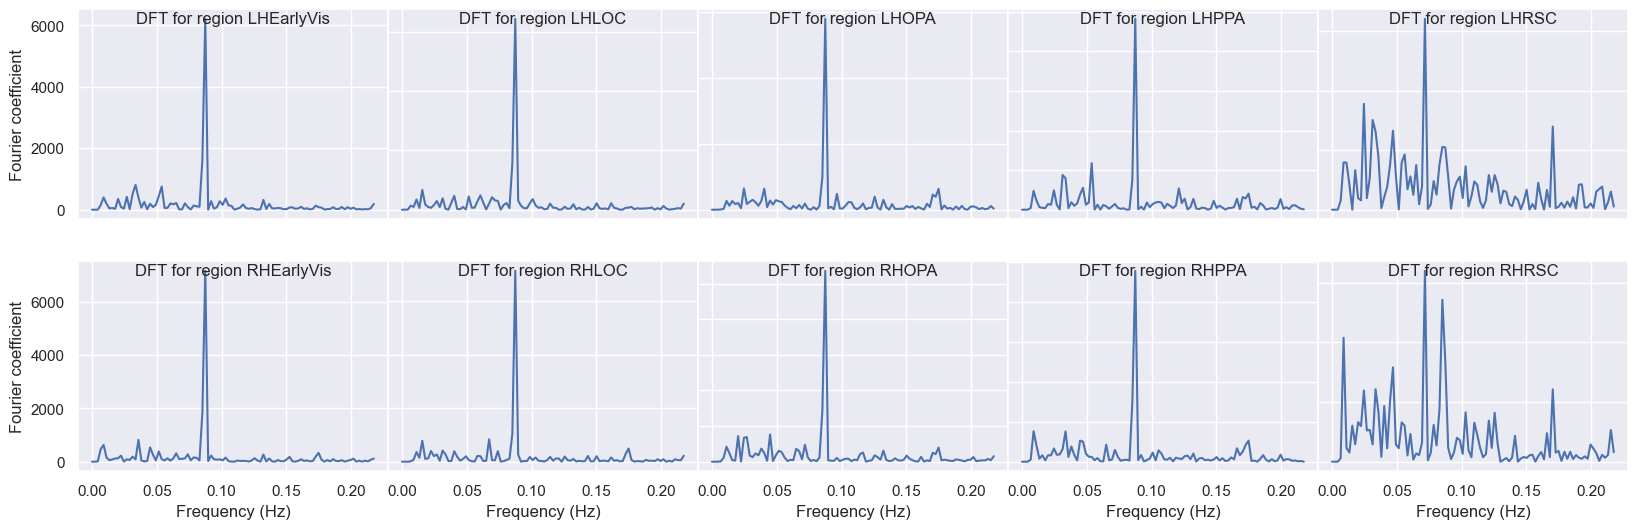

In [62]:
# ---- Compute DFT ----
plot = False
if plot :
    sampling_freq = 1 / 2.3 # 1 / TR
    n_samples = all_TS[0].shape[0]

    fig, ax = plt.subplots(2, 5, figsize=(20, 6))
    regions = np.arange(10)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]-1, -1, -1):
            idx = regions[i*5+j]
            fourier = abs(rfft(all_TS[0][:, idx])) ** 2
            freqs = rfftfreq(n=n_samples, d=1.0 / sampling_freq)

            ax[i,j].plot(freqs, fourier)
            
            
            if i == 1:
                ax[i,j].set_xlabel("Frequency (Hz)")
            else:
                ax[i, j].tick_params('x', labelbottom=False)
            if j > 0:
                ax[i, j].tick_params('y', labelleft=False)

            ax[i, j].set_title(f"DFT for region {ROIs_labels[idx]}", pad=-10)

        _ = ax[i,j].set_ylabel("Fourier coefficient")
    fig.subplots_adjust(wspace=0)
    # fig.savefig(figure_folder / 'DFT_TS.png')

In [51]:
# --- Compute Spectrogram ---
plot = False
if plot :
    fig, ax = plt.subplots(2, 5, figsize=(20, 6))
    regions = np.arange(10)

    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]-1, -1, -1):
            idx = regions[i*5+j]
            f, t, Zxx = stft(all_TS[0][:, idx],
                             fs=sampling_freq, 
                             nperseg=20, noverlap=10) #nperseg : nbr de pts par seconde, nbr d'échantillon par fenêtre

            ax[i,j].pcolormesh(t, f, np.abs(Zxx), vmin=0, shading="gouraud")
            if i == 1:
                ax[i, j].set_xlabel("Time (s)")
            else:
                ax[i, j].tick_params('x', labelbottom=False)
            if j >0:
                ax[i, j].tick_params('y', labelleft=False)

            ax[i, j].set_title(f"STFT for region {ROIs_labels[idx]}")

        _ = ax[i, j].set_ylabel("Frequency (Hz)")
    fig.subplots_adjust(wspace=0)
    fig.savefig(figure_folder / 'spectrogram_TS.png')

In [67]:
# --- Plot time series' boxplot ---
# fig = plt.figure()
# bplot = plt.boxplot(time_series, 
#             patch_artist=True,
#             positions=np.arange(1, 11),
#             # showmeans=True,
#             )
# plt.xlabel('Regions')
# plt.xticks(np.arange(1, 11), ROIs_labels, rotation=45)
# # for patch, color in zip(bplot['boxes'], color_brain_regions):
# #         patch.set_facecolor(color)
# fig.tight_layout()
# plt.show()
# fig.savefig(figure_folder / 'boxplot_time_series.png')

For the same subject, distribution of fMRI BOLD Values for each brain regions are plotting across all time points. 

Brain regions exhibit similar level of of variability. It may be due to the preprocessing and the way the time series were extracted. (in taking into account the confounds)

## Compute connectivity

In the following section, we illustrate the following concept with an example.

In [6]:
idx_sub = np.random.randint(10)
print(f'--- Example with patient {idx_sub} ---')
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([all_TS[idx_sub]])[0]

print('Connectivity', correlation_matrix.shape)

# fig = plt.figure()
# plotting.plot_matrix(correlation_matrix)
# fig.savefig(figure_folder / 'connectivity_matrix.png')
# plt.show()

--- Example with patient 6 ---
Connectivity (10, 10)


In [11]:
# Compute coordinates of the brain regions for plotting
coordinates = plotting.find_probabilistic_atlas_cut_coords(ROIs_maps_filename)
print(coordinates.shape)

(10, 3)


In [23]:
plot = False
if plot :
    plotting.plot_connectome(correlation_matrix,
                            coordinates,
                            #  edge_threshold="100%",
                            title=' Brain graph',
                            output_file=figure_folder / 'brain_graph.png')
    plt.show()

In [70]:
# view = plotting.view_connectome(
#     correlation_matrix, coordinates,
# )
# view

# Compute brain graph 
 Construct connectivity matrix and graph (node feature + adjacency matrix )

We considere weighed adjacency matrix $A\in\mathbb{R}^{N\times N}$ mirroring what was done in the paper

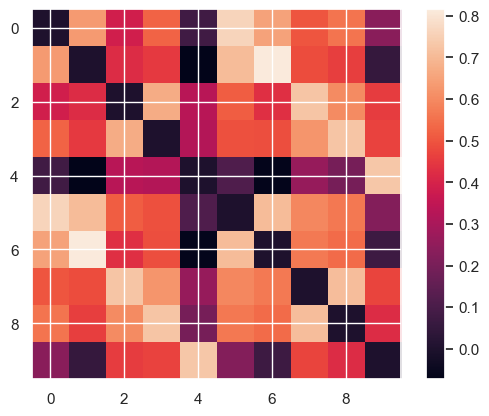

In [7]:
np.fill_diagonal(correlation_matrix, 0)

fig = plt.figure()
plt.imshow(correlation_matrix)
plt.colorbar()
# fig.savefig(figure_folder / 'connectivity_matrix.png')
plt.show()

In [8]:
brain_graph_idx = graphs.Graph(correlation_matrix)

In [9]:
nb_regions = brain_graph_idx.N
try :
    brain_graph_idx.compute_fourier_basis() # recompute=True
    print(f'Graph eigenvalues : {brain_graph_idx.e.shape}')
    print(f'Graph eigenvectors : {brain_graph_idx.U.shape}')
except :
    print('Error computing the Fourier basis for idx=', idx_sub)
    # start again
    brain_graph_idx.compute_fourier_basis() # recompute=True
    print(f'Graph eigenvalues : {brain_graph_idx.e.shape}')
    print(f'Graph eigenvectors : {brain_graph_idx.U.shape}')

Graph eigenvalues : (10,)
Graph eigenvectors : (10, 10)


# Filtering 

In the studied article, they perform graph signal filtering with two different filtering matrices 

$\psi_{Al}$ : low pass filtering for alignment; so that $Y_{\phi_{Al}} = V\psi_{Al}V^TX$ is the transformed functional data in which only the then lowest frequency modes are expressed 

$\psi_{Li}$ : high-pass filtering; for liberality, only the ten highest frequency modes 
to derive a subject-specific alignment and liberality concentration, they compute the norms of the filtered signal, averaged across all temporal samples of a given subject.

In [12]:
print(coordinates.shape)
brain_graph_idx.set_coordinates(coordinates)

(10, 3)


In [14]:
def continuous_low_pass_filter(x, tau=3.):
    return 1. / (1. + tau * x)

def continuous_high_pass_filter(x, r=5., tau=1):
    # return r * x / (1 + tau*x)
    return 2 / ( 1 + np.exp(-tau *(x - r)))

def al_pass_filter(x, threshold=0.1):
    return (x <= threshold) * 1

def li_pass_filter(x, threshold=0.1):
    return (x >= threshold) * 1


def get_discrete_filter_graph(G: graphs.Graph,
                              type_pass: str = 'low',
                              n_freq_to_select: int=2)-> Callable:
    if type_pass == 'low':
        threshold_eig = G.e[n_freq_to_select-1]
        filter_func = al_pass_filter
    else:
        threshold_eig = G.e[-n_freq_to_select]
        filter_func = li_pass_filter

    return partial(filter_func, threshold=threshold_eig)
    

In [16]:
# ---- Illustration with an example ----
val = brain_graph_idx.e
al_g = filters.Filter(brain_graph_idx, get_discrete_filter_graph(brain_graph_idx, type_pass='low'))
li_g = filters.Filter(brain_graph_idx, get_discrete_filter_graph(brain_graph_idx, type_pass='high'))
cont_low = filters.Filter(brain_graph_idx, continuous_low_pass_filter)
cont_high = filters.Filter(brain_graph_idx, continuous_high_pass_filter)

In [ ]:
# ---- Plot filters ----
plot = False
if plot :
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ax[0, 0].vlines(x=val, ymin=0, ymax=1, color='gray', alpha=.5)
    al_g.plot(plot_eigenvalues=True, ax=ax[0, 0])
    _ = ax[0, 0].set_title('Alignment Filter ')

    ax[0, 1].vlines(x=val, ymin=0, ymax=1, color='gray', alpha=.5)
    li_g.plot(plot_eigenvalues=True, ax=ax[0, 1])
    _ = ax[0, 1].set_title('Liberality Filter')

    ax[1, 0].vlines(x=val, ymin=0, ymax=1, color='gray', alpha=.5)
    cont_low.plot(plot_eigenvalues=True, ax=ax[1, 0])
    ax[1, 0].set_title('Continuous Low pass')

    ax[1, 1].vlines(x=val, ymin=0, ymax=1, color='gray', alpha=.5)
    cont_high.plot(plot_eigenvalues=True, ax=ax[1, 1])
    ax[1, 1].set_title('Continuous High pass')


    fig.tight_layout()
    fig.savefig(figure_folder / 'plot_filters.png')

In [17]:
signal = all_TS[idx_sub].T
print(f"signal shape : {signal.shape}")
al_filtered_signal = al_g.filter(signal)
li_filtered_signal = li_g.filter(signal)
cont_low_filtered_signal = cont_low.filter(signal)
cont_high_filtered_signal = cont_high.filter(signal)

signal shape : (10, 194)


In [18]:
# # ---- Plot filtered signal ----
# fig, ax = plt.subplots(3, 1, figsize=(10, 3))
# ax[0].imshow(signal, aspect='auto')
# ax[0].set_title('Original signal')
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# ax[0].set_axis_off()
# ax[0].annotate("", xy=(-8, -5), xytext=(-8, 40), xycoords='axes points',
#             arrowprops=dict(arrowstyle="->", color='black'))
# ax[1].imshow(cont_low_filtered_signal, aspect='auto')
# ax[1].set_title('Low-pass filtered signal')
# ax[1].set_axis_off()
# ax[1].annotate("", xy=(-8, -5), xytext=(-8, 40), xycoords='axes points',
#             arrowprops=dict(arrowstyle="->", color='black'))
# ax[2].imshow(cont_high_filtered_signal, aspect='auto')
# ax[2].set_title('High-pass filtered signal')
# ax[2].set_axis_off()
# ax[2].annotate("", xy=(-8, -5), xytext=(-8, 40), xycoords='axes points',
#             arrowprops=dict(arrowstyle="->", color='black'))

# # plotting.plot_markers(signal[:, 0], coordinates, axes=ax[1])

# fig.tight_layout()
# fig.savefig(figure_folder / 'ex_filtered_signal.png')

In [19]:
# ---- Plot filtered signal on the graph ----
# fig, ax = plt.subplots(3, 1, figsize=(10, 9))

# plotting.plot_markers(signal[:, 0], coordinates,
#                       title='Original signal', 
#                       axes=ax[0])
# ax[0].set_title('Original signal')

# plotting.plot_markers(cont_low_filtered_signal[:, 0], coordinates,
#                       title='Low-pass filtered signal',
#                       axes=ax[1])

# plotting.plot_markers(cont_high_filtered_signal[:, 0], coordinates,
#                       title='High-pass filtered signal',
#                       axes=ax[2])

# fig.savefig(figure_folder / 'ex_filtered_signal_markers.png')

# Experiment 2 : Extract Excursions in Alignment and Liberality regimes
In this section, we investigate the following questions :
- In our setting with only 10 regions, can we exhibit regions with frequent moments of strong alignment and liberality ?
- What do we obtain if we apply the classical phase Fourier randomization ?
- Does the choice of low pass or high pass filter influence the percentage of significant excursions ?

Mirroring the approach of the authors, we propose a non-parametric, model-free statistical test for identifying unexpected fluctuations in time series magnitude over time. 

We compute the average of the 95% (and 5% for significant low amplitude) percentile on the surrogate signals. The obtained value is used to threshold the "true" time series. The time point that exceed this threshold are said to be significant excursions. 


The protocol is repeated for all the 10 runs and statistical results are plotted on a boxplot. For each run, we generate 1000 null surrogate graph signal.

The authors of the article chose the 12% smallest and largest eigenvalues for the alignment and liberality filters, respectively. It goes down to 2 eigenvalues for our graph.

In [33]:
def phase_randomization_matrix(dim :int = 10):
    diag = np.random.choice([-1, 1], size=dim)
    return np.diag(diag)

def compute_graph_surrogate_signals(signal: np.ndarray,
                              G: graphs.Graph,
                              N:int = 1000)-> np.ndarray:
    dim = G.N
    coeff_fourier = G.U.T @ signal 
    surrogate = []
    for _ in range(N):
        phi_graph = phase_randomization_matrix(dim=dim)
        print(phi_graph.sum())
        surrogate.append( G.U @ phi_graph @ coeff_fourier )

    return np.array(surrogate)

def compute_Fourier_surrogate_signals(signal: np.ndarray,
                                      N: int = 1000) -> np.ndarray:
    # raise NotImplementedError
    coeff_fourier = rfft(signal, axis=1) # (nb_regions, nb_coeff)
    surrogates = []
    for _ in range(N):
        phi_fourier = phase_randomization_matrix(dim=coeff_fourier.shape[1])
        surrogates.append(
            irfft(coeff_fourier @ phi_fourier)
        )

    return np.array(surrogates)
        

def compute_significant_excursion(all_TS: np.ndarray, 
                                  protocol: dict,
                                  Nsimu : int = 1000,
                                  plot : bool = False,
                                  results_folder : Path = results_folder):
    nb_run, nb_time, nb_regions = all_TS.shape
    # compute connectivity matrices
    connectivity_measure = ConnectivityMeasure(
            kind="correlation",
            standardize="zscore_sample",
        )
    connectivity_matrices = connectivity_measure.fit_transform([*all_TS])
    metrics = {
        'mean_percentile_high' : [],
        'std_percentile_high' : [],
        # 'mean_percentile_low' : [],
        # 'std_percentile_low' : [],
        'percentage_excursions' : [],
    }

    for i in tqdm(range(nb_run), desc='Compute excursion for each run'):


        # compute graph
        np.fill_diagonal(connectivity_matrices[i], 0)
        brain_graph = graphs.Graph(connectivity_matrices[i])
        
        assert brain_graph.N == nb_regions
        try :
            brain_graph.compute_fourier_basis()
        except :
            print(f'Error computing Fourier basis for run {i}')
            brain_graph.compute_fourier_basis()
            # continue

        # compute filters
        if protocol['TYPE_FILTER'] == 'continuous':
            filter_kernel = filters.Filter(brain_graph, eval('{TYPE_FILTER}_{FILTER}_pass_filter'.format(**protocol)))
        else:
            filter_kernel = filters.Filter(brain_graph,
                                    get_discrete_filter_graph(brain_graph, type_pass = protocol['FILTER'])
                                    )
        
        # filter signal
        signal = all_TS[i].T
        filtered_signal = filter_kernel.filter(signal)

        # surrogate (Nsimu, nb_regions, nb_time)
        if protocol['RANDOMIZATION'] == 'graph':
            surrogates = compute_graph_surrogate_signals(filtered_signal,
                                                brain_graph, 
                                                N=Nsimu)
        else:
            surrogates = compute_Fourier_surrogate_signals(filtered_signal,
                                                           N=Nsimu)
            
        abs_surrogates = np.abs(surrogates)
        # surrog_percentiles_low = np.percentile(abs_surrogates, protocol['PERCENTILE'][0], axis=2)
        surrog_percentiles_high = np.percentile(abs_surrogates, protocol['PERCENTILE'][1], axis=2)
        metrics['mean_percentile_high'].append(np.mean(surrog_percentiles_high, axis=0))
        metrics['std_percentile_high'].append(np.std(surrog_percentiles_high, axis=0))
        # metrics['mean_percentile_low'].append(np.mean(surrog_percentiles_low, axis=0))
        # metrics['std_percentile_low'].append(np.std(surrog_percentiles_low, axis=0))

        # compute significant excursion
        abs_signal = np.abs(filtered_signal)
        isexcursion_high = abs_signal > metrics['mean_percentile_high'][-1][:, None]
        # isexcursion_low = abs_signal < metrics['mean_percentile_low'][-1][:, None]

        metrics['percentage_excursions'].append(
            isexcursion_high.sum(axis=1)*100 / nb_time
        )

    if plot :
        
        # surrogates
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        ax[0].plot(abs_surrogates[:6, 0, :].T)
        ax[0].axhline(metrics['mean_percentile_high'][-1][0], color='red', label='mean $p_{95}$', alpha=.3)
        ax[0].axhline(metrics['mean_percentile_high'][-1][0] + metrics['std_percentile_high'][-1][0], color='black', linestyle='--', label='std $p_{95}$', alpha=.3)
        ax[0].axhline(metrics['mean_percentile_high'][-1][0]-metrics['std_percentile_high'][-1][0], color='black', linestyle='--', alpha=.3)
        ax[0].legend()
        ax[0].set_title('Test statistic $p_{95}$')

        fig.savefig(figure_folder / 'plot_ex_surrogate.png')

        # signal
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        ax[0].plot(abs_signal[0, :].T)
        ax[0].axhline(metrics['mean_percentile_high'][-1][0], color='red', label='mean $p_{95}$', alpha=.3)
        ax[0].axhline(metrics['mean_percentile_high'][-1][0] + metrics['std_percentile_high'][-1][0], color='black', linestyle='--', label='std $p_{95}$', alpha=.3)
        ax[0].axhline(metrics['mean_percentile_high'][-1][0]-metrics['std_percentile_high'][-1][0], color='black', linestyle='--', alpha=.3)
        ax[0].legend()
        ax[0].set_title('Test statistic $p_{95}$')

        fig.savefig(figure_folder / 'plot_ex_signal_stats.png')


    # save results
    output_path = results_folder / '{FILTER}_{TYPE_FILTER}_filter_{RANDOMIZATION}_randomization.pkl'.format(**protocol)
    with open(output_path, 'wb') as outfile :
        pickle.dump(metrics, outfile)

    return metrics
        
        

In [105]:
for exp in [protocol_1, protocol_2, protocol_3, protocol_4]:
    metrics = compute_significant_excursion(all_TS, exp, plot=False)

Compute excursion for each run:   0%|          | 0/20 [00:00<?, ?it/s]

Compute excursion for each run:  15%|█▌        | 3/20 [00:00<00:02,  5.94it/s]2023-12-16 21:42:33,458:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Error computing Fourier basis for run 3


Compute excursion for each run:  75%|███████▌  | 15/20 [00:02<00:00,  7.43it/s]

Error computing Fourier basis for run 14


Compute excursion for each run:  85%|████████▌ | 17/20 [00:02<00:00,  7.78it/s]

Error computing Fourier basis for run 16


Compute excursion for each run: 100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Error computing Fourier basis for run 19


Compute excursion for each run:  20%|██        | 4/20 [00:00<00:01,  8.63it/s]

Error computing Fourier basis for run 3


Compute excursion for each run:  75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

Error computing Fourier basis for run 14


Compute excursion for each run:  85%|████████▌ | 17/20 [00:02<00:00,  7.06it/s]

Error computing Fourier basis for run 16


Compute excursion for each run: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


Error computing Fourier basis for run 19


Compute excursion for each run:  20%|██        | 4/20 [00:00<00:02,  6.60it/s]

Error computing Fourier basis for run 3


Compute excursion for each run:  75%|███████▌  | 15/20 [00:02<00:00,  7.04it/s]

Error computing Fourier basis for run 14


Compute excursion for each run:  85%|████████▌ | 17/20 [00:02<00:00,  7.28it/s]

Error computing Fourier basis for run 16


Compute excursion for each run: 100%|██████████| 20/20 [00:02<00:00,  7.13it/s]


Error computing Fourier basis for run 19


Compute excursion for each run:  20%|██        | 4/20 [00:00<00:02,  6.81it/s]

Error computing Fourier basis for run 3


Compute excursion for each run:  75%|███████▌  | 15/20 [00:02<00:00,  6.20it/s]

Error computing Fourier basis for run 14


Compute excursion for each run:  85%|████████▌ | 17/20 [00:02<00:00,  6.38it/s]

Error computing Fourier basis for run 16


Compute excursion for each run: 100%|██████████| 20/20 [00:03<00:00,  6.61it/s]

Error computing Fourier basis for run 19


In [19]:
for exp in [protocol_5, protocol_6]:
    metrics = compute_significant_excursion(all_TS, exp, plot=False)

Compute excursion for each run:   0%|          | 0/20 [00:00<?, ?it/s]

Compute excursion for each run:  15%|█▌        | 3/20 [00:01<00:06,  2.56it/s]2023-12-16 23:17:51,385:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Error computing Fourier basis for run 3


Compute excursion for each run:  70%|███████   | 14/20 [00:05<00:02,  2.59it/s]2023-12-16 23:17:55,608:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Error computing Fourier basis for run 14


Compute excursion for each run:  80%|████████  | 16/20 [00:06<00:01,  2.37it/s]2023-12-16 23:17:56,550:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Error computing Fourier basis for run 16


Compute excursion for each run:  95%|█████████▌| 19/20 [00:07<00:00,  2.36it/s]2023-12-16 23:17:57,862:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Error computing Fourier basis for run 19


Compute excursion for each run:  15%|█▌        | 3/20 [00:01<00:06,  2.61it/s]2023-12-16 23:17:59,538:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Error computing Fourier basis for run 3


Compute excursion for each run:  70%|███████   | 14/20 [00:05<00:02,  2.61it/s]2023-12-16 23:18:04,166:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Error computing Fourier basis for run 14


Compute excursion for each run:  80%|████████  | 16/20 [00:06<00:01,  2.55it/s]2023-12-16 23:18:04,969:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Error computing Fourier basis for run 16


Compute excursion for each run:  95%|█████████▌| 19/20 [00:07<00:00,  2.54it/s]2023-12-16 23:18:06,192:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Error computing Fourier basis for run 19


Compute excursion for each run: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


In [20]:
def plot_results(metrics: dict, protocol: dict):

    if not isinstance(metrics['percentage_excursions'], np.ndarray):
        metrics['percentage_excursions'] = np.array(metrics['percentage_excursions'])

    nb_runs = metrics['percentage_excursions'].shape[0]
    fig, ax = plt.subplots(1)
    plt.boxplot(metrics['percentage_excursions'],
                patch_artist=True,
                positions=np.arange(1, 11),
    )
    plt.xlabel('Regions')
    plt.xticks(np.arange(1, 11), ROIs_labels, rotation=45)
    plt.ylabel('Percentage of excursion (%)')
    plt.title(f'Computed on {nb_runs} runs', fontsize=8)
    fig.tight_layout()

    fig.savefig(figure_folder / '{FILTER}_{TYPE_FILTER}_filter_{RANDOMIZATION}_randomization.png'.format(**protocol))


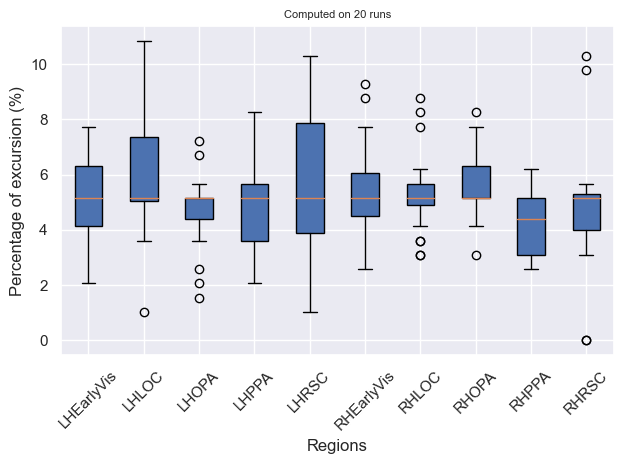

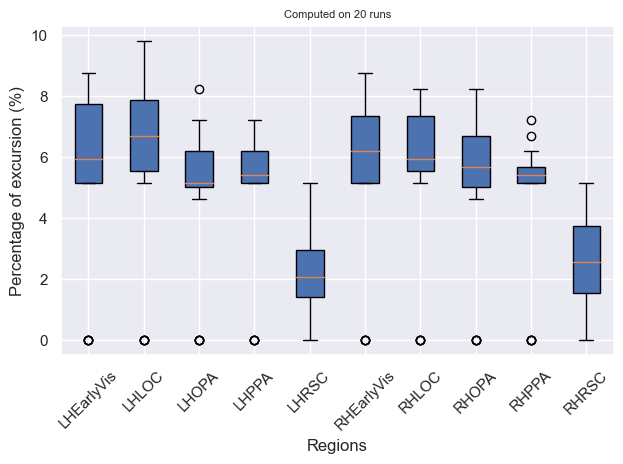

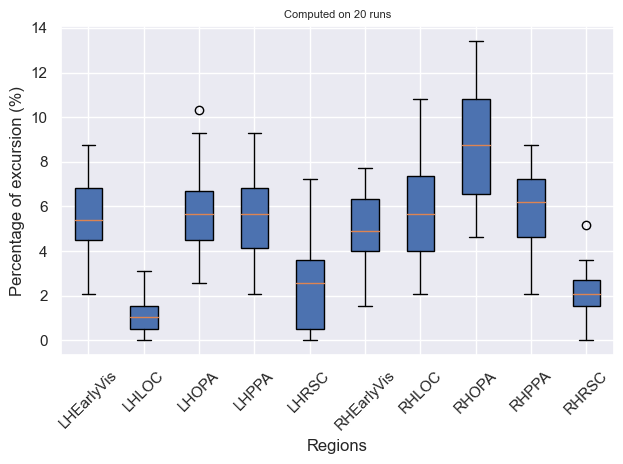

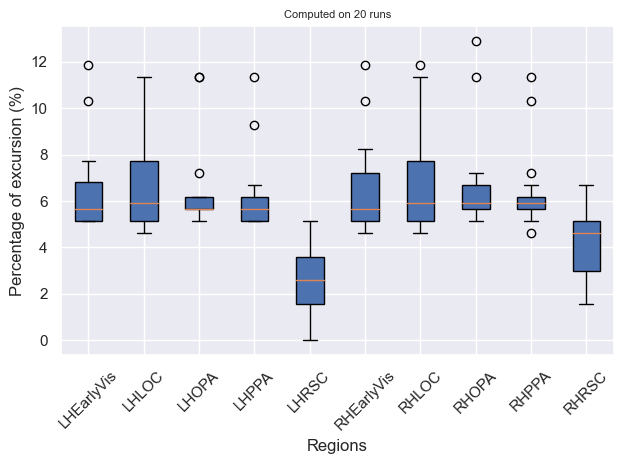

In [110]:
for exp in [protocol_1, protocol_2, protocol_3, protocol_4]:
    result_path = results_folder / '{FILTER}_{TYPE_FILTER}_filter_{RANDOMIZATION}_randomization.pkl'.format(**exp)
    with open(result_path, 'rb') as infile:
        metrics = pickle.load(infile)
        plot_results(metrics, exp)

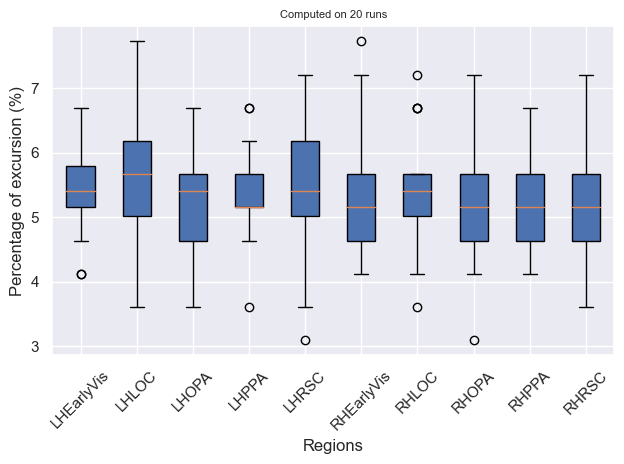

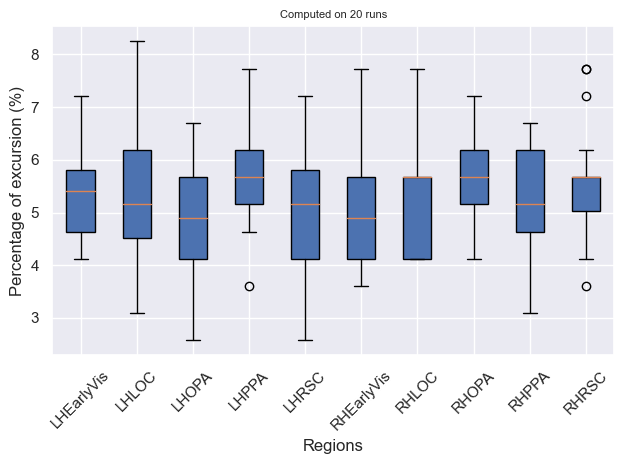

In [21]:
for exp in [protocol_5, protocol_6]:
    result_path = results_folder / '{FILTER}_{TYPE_FILTER}_filter_{RANDOMIZATION}_randomization.pkl'.format(**exp)
    with open(result_path, 'rb') as infile:
        metrics = pickle.load(infile)
        plot_results(metrics, exp)